In [1]:
from __future__ import division

import sys
sys.path.append('/Users/j0406142/Documents/Python/ploutos/')
from ploutos import MicrogridGenerator as mg

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
m_gen=mg.MicrogridGenerator()
m_gen.generate_microgrid()

            Load
0     694.828419
1     694.828419
2     694.828419
3     694.828419
4     749.510964
...          ...
8755  975.635235
8756  975.635235
8757  965.927870
8758  720.337417
8759  720.337417

[8760 rows x 1 columns]
7299388
{'capa': 2499.7904109589044, 'pcharge': 624.9476027397261, 'pdischarge': 624.9476027397261, 'soc_max': 1, 'soc_min': 0.2, 'efficiency': 0.9, 'soc_0': 0.473860833744823, 'cost_cycle': 0.3}


In [3]:
m_gen.microgrids[0].parameters


,load,cost_loss_load,PV_rated_power,battery_soc_0,battery_power_charge,battery_power_discharge,battery_capacity,battery_efficiency,battery_soc_min,battery_soc_max,battery_cost_cycle,genset_polynom_order,genset_polynom_0,genset_polynom_1,genset_polynom_2,genset_rated_power,genset_pmin,genset_pmax,fuel_cost
0,7299388,10000,6861424.72,0.473861,624.947603,624.947603,2499.790411,0.9,0.2,1,0.3,3,4.458328,0.099975,0.045925,1248.466578,0.2,0.9,0.4


In [5]:
m_gen.microgrids[0].architecture

{'PV': 1, 'battery': 1, 'genset': 1, 'grid': 0}

In [4]:
m_gen.microgrids[0].df_status

,net_load,battery_soc
0,0,0.473861


In [ ]:
#example of control_dict
control_dict = {'battery_charge': p_charge.value[0],
                            'battery_discharge': p_discharge.value[0],
                            'genset': p_genset.value[0],
                            'grid_import': p_grid_import.value[0],
                            'grid_export': p_grid_export.value[0],
                            'load_not_matched': p_loss_load.value[0],
                            'pv_consummed': pv[0]-p_curtail_pv.value[0],
                            'pv_curtailed': p_curtail_pv.value[0]}



In [7]:
for i in range(1000):
    state = m_gen.microgrids[0].df_status.iloc[-1]
    load = m_gen.microgrids[0].load.iloc[i].values[0]
    pv = m_gen.microgrids[0].pv.iloc[i].values[0]
    
    control_dict = {'battery_charge': 0,
                            'battery_discharge': 0,
                            'genset': max(0, load-pv),
                            'grid_import': 0,
                            'grid_export':0,
                            'load_not_matched': 0,
                            'pv_consummed': min(pv, load),
                            'pv_curtailed':min(load-pv, 0)}
    
    
    mg_data = m_gen.microgrids[0].run(control_dict, i)

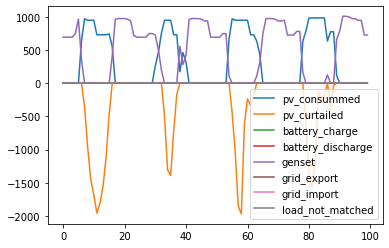

In [12]:
m_gen.microgrids[0].df_actions.iloc[:100,:].plot()

In [72]:
m_gen=mg.MicrogridGenerator()
m_gen.generate_microgrid()

#setting up action and state space
nb_state=2
nb_action=4
#battery SOC, net load ?
state = np.array((nb_state))
action= np.array((nb_action))
# priority list ?
def mg_action(action, load, pv, status, parameters):
    
    control_dict= []
    capa_to_charge = max(
                        (parameters['battery_soc_max'].values[0] * parameters['battery_capacity'].values[0] -
                         status['battery_soc'] *
                         parameters['battery_capacity'].values[0]
                         ) *parameters['battery_efficiency'].values[0], 0)
    capa_to_discharge = max((status['battery_soc'] *
                                             parameters['battery_capacity'].values[0]
                                             - parameters['battery_soc_min'].values[0] *
                                             parameters['battery_capacity'].values[0]
                                             ) * parameters['battery_efficiency'].values[0], 0)
    # state 0 genset covers what needs to be covered
    if action == 0:
        control_dict = {'battery_charge': 0,
                            'battery_discharge': 0,
                            'genset': max(0, load-pv),
                            'grid_import': 0,
                            'grid_export':0,
                            'load_not_matched': 0,
                            'pv_consummed': min(pv, load),
                            'pv_curtailed':min(load-pv, 0)}
    
    # state 1 to charge the battery in case of excess PV    
    elif action ==1:
        control_dict = {'battery_charge': max(0, min(capa_to_charge, parameters['battery_power_charge'].values[0],
                                             pv-load)),
                            'battery_discharge': 0,
                            'genset': max(0, load-pv),
                            'grid_import': 0,
                            'grid_export':0,
                            'load_not_matched': 0,
                            'pv_consummed': min(pv, load),
                            'pv_curtailed':min(load- max(0, min(capa_to_charge, parameters['battery_power_charge'].values[0],
                                             pv-load))-pv, 0)}
        
    # state 2 discharge the battery, cover the rest with genset
    elif action ==2:
        control_dict = {'battery_charge': 0,
                            'battery_discharge': max(0, min(capa_to_discharge, parameters['battery_power_discharge'].values[0],
                                                load-pv)),
                            'genset': max(0, load-pv-max(0, min(capa_to_discharge, parameters['battery_power_discharge'].values[0],
                                                load-pv))),
                            'grid_import': 0,
                            'grid_export':0,
                            'load_not_matched': 0,
                            'pv_consummed': min(pv, load),
                            'pv_curtailed':min(load-pv, 0)}
        
    # do not cover the load 
    elif action == 3:
        control_dict = {'battery_charge': 0,
                            'battery_discharge': 0,
                            'genset': 0,
                            'grid_import': 0,
                            'grid_export':0,
                            'load_not_matched': load,
                            'pv_consummed': 0,
                            'pv_curtailed':pv}
        
    
    return control_dict

def compute_reward (control_dict, parameters):
    
    cost = -control_dict['genset']*parameters['fuel_cost'].values[0]-control_dict['load_not_matched']*parameters['cost_loss_load'].values[0]


    return cost

            Load
0     694.828419
1     694.828419
2     694.828419
3     694.828419
4     749.510964
...          ...
8755  975.635235
8756  975.635235
8757  965.927870
8758  720.337417
8759  720.337417

[8760 rows x 1 columns]
7299388
{'capa': 2499.7904109589044, 'pcharge': 624.9476027397261, 'pdischarge': 624.9476027397261, 'soc_max': 1, 'soc_min': 0.2, 'efficiency': 0.9, 'soc_0': 0.473860833744823, 'cost_cycle': 0.3}


In [78]:
q_table = np.zeros([nb_state, nb_action])


# Hyperparameters
alpha = 0.1
gamma = 0.6
epsilon = 0.1

# For plotting metrics
all_epochs = []
all_penalties = []
parameters = m_gen.microgrids[0].parameters
for i in range(1, 1000):
    status = m_gen.microgrids[0].df_status.iloc[-1]
    load = m_gen.microgrids[0].load.iloc[i].values[0]
    pv = m_gen.microgrids[0].pv.iloc[i].values[0]
    
    if load - pv > 0:
        state =0
    else:
        state =1

    epochs, penalties, reward, = 0, 0, 0
    done = False
    
    #while not done:
    rand = np.random.randn()
    if rand < epsilon:
        if rand < 0.025:
            action = 0
        elif rand >= 0.025 and rand < 0.050:
            action =1 
        elif rand >= 0.05 and rand < 0.075:
            action =2
        elif rand >= 0.075:
             action = 3# Explore action space
    else:
        action = np.argmax(q_table[state]) # Exploit learned values


    control_dict = mg_action(action, load, pv, status, parameters)
    #print (action)
    #print (control_dict)
    mg_data = m_gen.microgrids[0].run(control_dict, i)
    reward =  compute_reward(control_dict, parameters)                                   



    next_load = m_gen.microgrids[0].load.iloc[i+1].values[0]
    next_pv = m_gen.microgrids[0].pv.iloc[i+1].values[0]

    if next_load - next_pv > 0:
        next_state =0
    else:
        next_state =1

    old_value = q_table[state, action]
    #print(old_value)
    next_max = np.max(q_table[next_state])

    new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
    q_table[state, action] = new_value

print("Training finished.\n")

Training finished.



In [79]:
q_table

array([[-5.62505784e+02, -7.19180810e+02, -4.62279426e+02,
        -5.90720361e+06],
       [-7.37098037e+01, -4.17426920e+01, -9.68338336e+01,
        -2.24905875e+06]])

In [80]:
reward

0.0

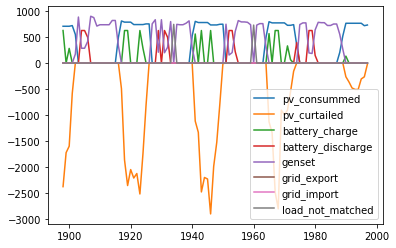

In [81]:
m_gen.microgrids[0].df_actions.iloc[-100:,:].plot()

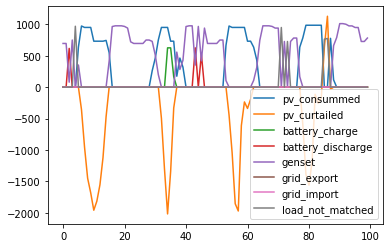

In [82]:
m_gen.microgrids[0].df_actions.iloc[:100,:].plot()